# Convolutional Neural Networks for Handwritten Digits Recognition
# New Test Dataset

**Objective**:

Building upon Lab 8 (focused on CNNs for handwritten digit recognition), the aim of this lab is to collect a new test set of handwritten digit images and evaluate your CNN models on this newly created dataset. 

If the performance is poor on the new test set, you should:
- Add the new test set to the MNIST training set,
- Retrain the model,
- Collect another test set,
- Reevaluate the performance."


**Dataset Collection:**

- The test set must be manually collected by the students. Each group is responsible for creating its own dataset.

- Within each group, one or two students will lead the collaborative effort to collect and organize the dataset:

   - Group 1: Farida Boubekeur, Meriem Mebarek Mansouri, Imene Ait Abdallah.

   - Group 4: Siniane Mira Thiziri, Bouderka Maroua

**Leader Responsibilities:** Group leaders are required to submit a report (hereafter) detailing the dataset creation process and providing an overview of the datasets' content.

**Individual Tasks:** Each student must evaluate the CNN model developed in Lab 8 using the newly created dataset and submit a report (hereafter) summarizing the results and observations (including the step in which the model is re-trained and re-evaluated).


### Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import mnist#, fashion_mnist
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard

from PIL import Image
from sklearn.utils import shuffle
import re

import os

from sklearn.model_selection import train_test_split
from random import sample
import matplotlib.pyplot as plt

### Importing datasets...

**MNIST**

In [2]:
(MNIST_x_train, MNIST_y_train), (MNIST_x_test, MNIST_y_test) = mnist.load_data()

num_classes = len(set(MNIST_y_train))

print("Number of train images", len(MNIST_y_train))
print("Number of test images", len(MNIST_y_test))
print("Number of classes", num_classes)
print("Image size", MNIST_x_train.shape[1:])

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of train images 60000
Number of test images 10000
Number of classes 10
Image size (28, 28)


**Our New Dataset (Collected for test)**

In [17]:
df_old = pd.read_csv('/kaggle/input/handwritten-digits-2/data/test_data.csv')

old_X = df_old.drop(['class', 'student name'], axis=1).to_numpy(dtype=float).reshape(-1, 28, 28)
old_y = df_old['class'].to_numpy(dtype=int)

print("Data loaded successfully!")
print(f"X shape: {old_X.shape}, y shape: {old_y.shape}")

Data loaded successfully!
X shape: (8968, 28, 28), y shape: (8968,)


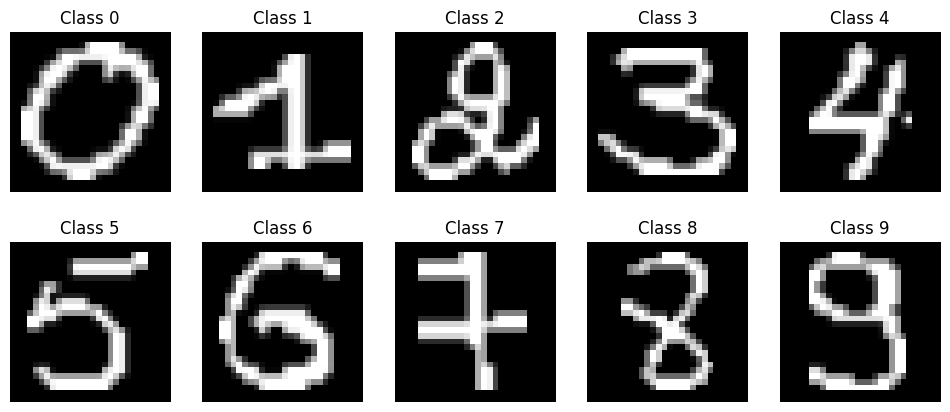

In [18]:
images = []
labels = []

for i, y in enumerate(old_y):
    if y in labels:
        continue
    
    labels.append(y)
    images.append(old_X[i])

fig = plt.figure(figsize = (12, 5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, i+1)
    img = images[i]
    lbl = labels[i]
    
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Class {lbl}")

plt.show()

**Our new Dataset (Collected for train)**

In [20]:
df_new = pd.read_csv('/kaggle/input/handwritten-digits-2/data/train_data.csv')

df_new['class'] = df_new['class'].astype(str).str.replace('(1)', '', regex=False)

new_X = df_new.drop(['class', 'student name'], axis=1).to_numpy(dtype=float).reshape(-1, 28, 28)
new_y = df_new['class'].to_numpy(dtype=int)

print("Data loaded successfully!")
print(f"X shape: {new_X.shape}, y shape: {new_y.shape}")

<ipython-input-20-13ddb17e1349>:1: DtypeWarning: Columns (784) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new = pd.read_csv('/kaggle/input/handwritten-digits-2/data/train_data.csv')


Data loaded successfully!
X shape: (40274, 28, 28), y shape: (40274,)


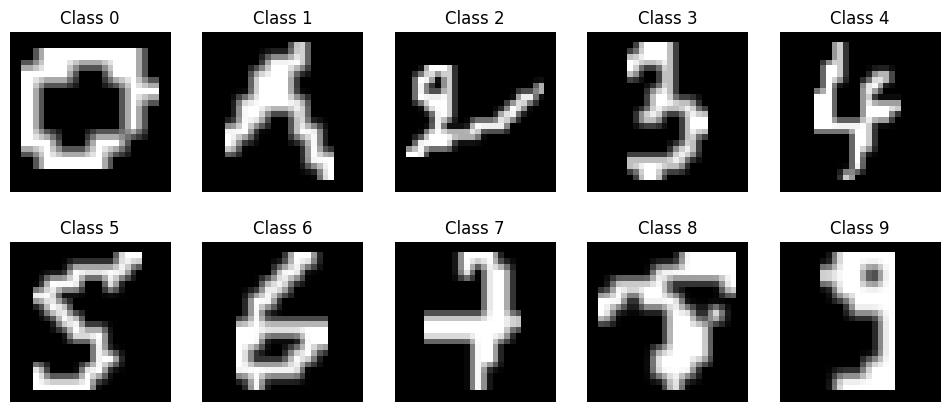

In [21]:
images = []
labels = []

for i, y in enumerate(new_y):
    if y in labels:
        continue
    
    labels.append(y)
    images.append(new_X[i])

fig = plt.figure(figsize = (12, 5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, i+1)
    img = images[i]
    lbl = labels[i]
    
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Class {lbl}")

plt.show()

### Model Definition

In [22]:
batch_size = 64
epochs = 20
learning_rate = 1e-3
l2_reg_rate = 0
dropout_rate = 0.2

loss_m = "SparseCategoricalCrossentropy"

In [23]:
def LeNet5(l2_reg, dropout):
    model = Sequential()
    model.add(InputLayer(shape = (28, 28, 1))) # you can use x_train.shape[1:] instead of (28, 28, 1)

    model.add(Conv2D(filters = 6, kernel_size = 5, kernel_regularizer = l2(l2_reg)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(2))

    model.add(Dropout(dropout))

    model.add(Conv2D(filters = 16, kernel_size = 5, kernel_regularizer = l2(l2_reg)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(2))

    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation('relu'))

    model.add(Dropout(dropout))

    model.add(Dense(84))
    model.add(Activation('relu'))

    model.add(Dropout(dropout))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    return model

## Experiment 1: Train only on the collected dataset

Let's train on the new dataset and test on our previously-collected one

In [24]:
x_train, x_val, y_train, y_val = train_test_split(new_X, new_y, test_size=0.2, random_state=42 ,shuffle=True)

x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = old_X / 255.0

y_test = old_y.copy()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_val = np.expand_dims(x_val, -1)

print("train-set size:", x_train.shape)
print("val-set size:", x_val.shape)
print("test-set size:", x_test.shape)

train-set size: (32219, 28, 28, 1)
val-set size: (8055, 28, 28, 1)
test-set size: (8968, 28, 28, 1)


In [25]:
model = LeNet5(dropout=dropout_rate, l2_reg=l2_reg_rate)

opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss = loss_m, metrics = ["accuracy"])

h = model.fit(x_train, y_train, epochs = epochs, batch_size=batch_size, validation_data = (x_val, y_val), shuffle = True)

Epoch 1/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.6107 - loss: 1.1622 - val_accuracy: 0.9384 - val_loss: 0.2146
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9018 - loss: 0.3217 - val_accuracy: 0.9526 - val_loss: 0.1588
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9277 - loss: 0.2346 - val_accuracy: 0.9642 - val_loss: 0.1284
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9387 - loss: 0.2072 - val_accuracy: 0.9644 - val_loss: 0.1222
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9486 - loss: 0.1761 - val_accuracy: 0.9705 - val_loss: 0.1046
Epoch 6/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9534 - loss: 0.1532 - val_accuracy: 0.9713 - val_loss: 0.1013
Epoch 7/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9562 - loss: 0.1449 - val_accuracy: 0.9736 - val_loss: 0.0939
Epoch 8/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9582 - loss: 0.1380 - val_accuracy: 

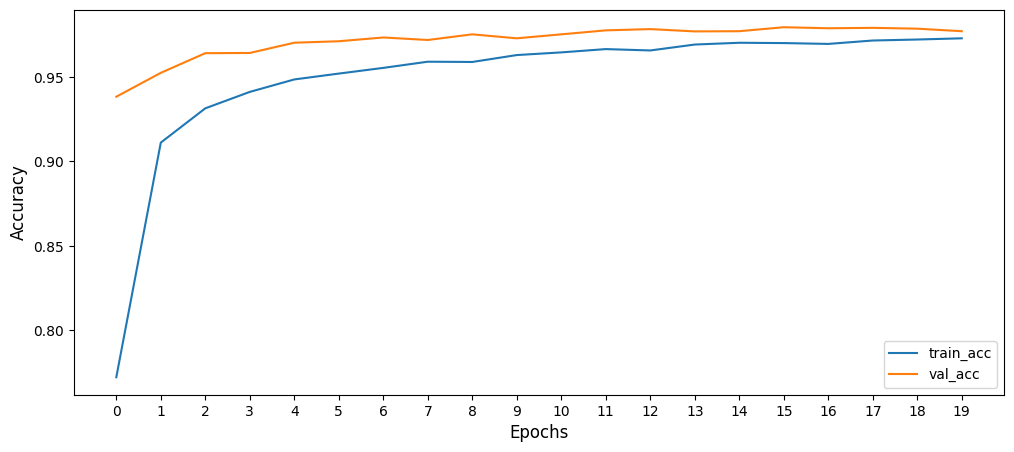

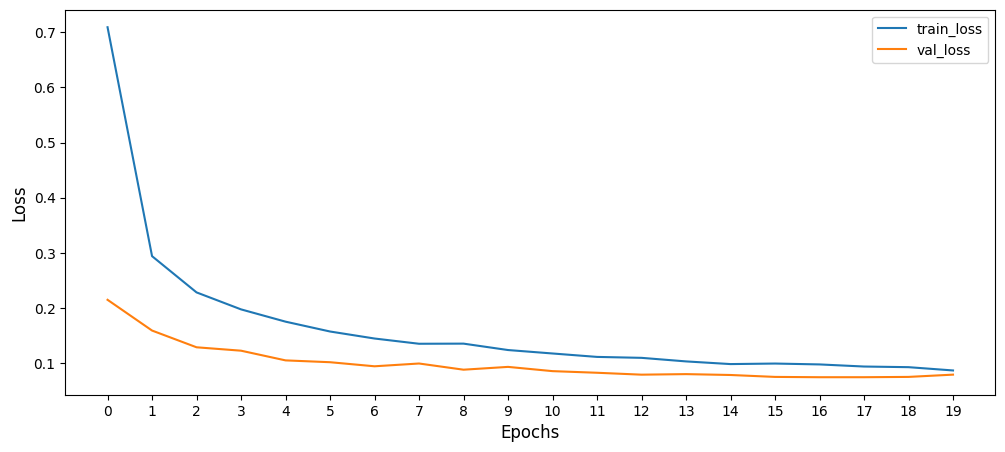

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(h.history["accuracy"], label = "train_acc")
plt.plot(h.history["val_accuracy"], label = "val_acc")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.xticks(range(epochs))
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(h.history["loss"], label = "train_loss")
plt.plot(h.history["val_loss"], label = "val_loss")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.xticks(range(epochs))
plt.legend()

plt.show()

In [27]:
print("Model evaluation on old data...")

loss, accuracy = model.evaluate(x_test, y_test)

Model evaluation on old data...
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9498 - loss: 0.1795


Wohooo! **94.98%** on our previously-collected dataset. Let's try and visualize 

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


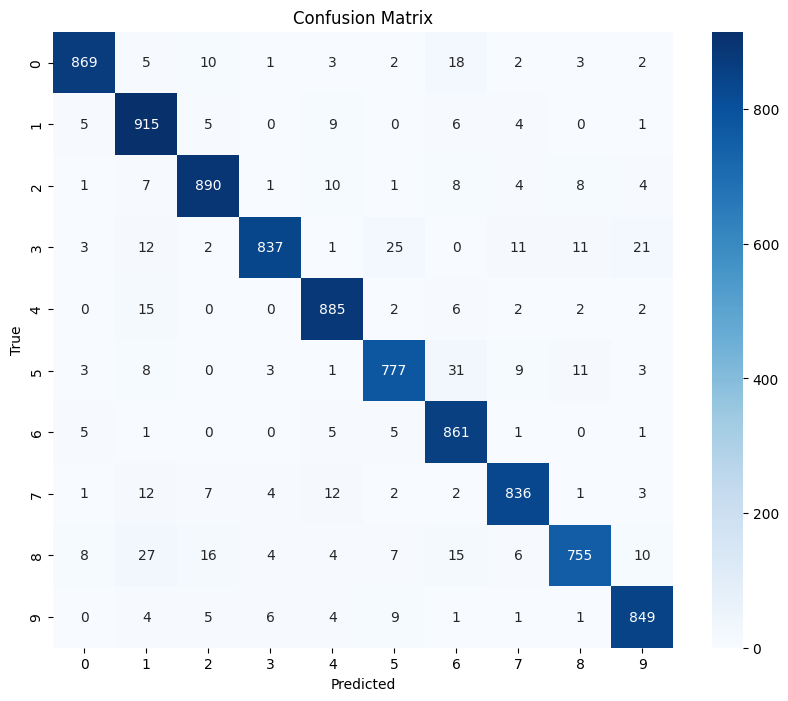

In [28]:
# visualize
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the classes for the test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

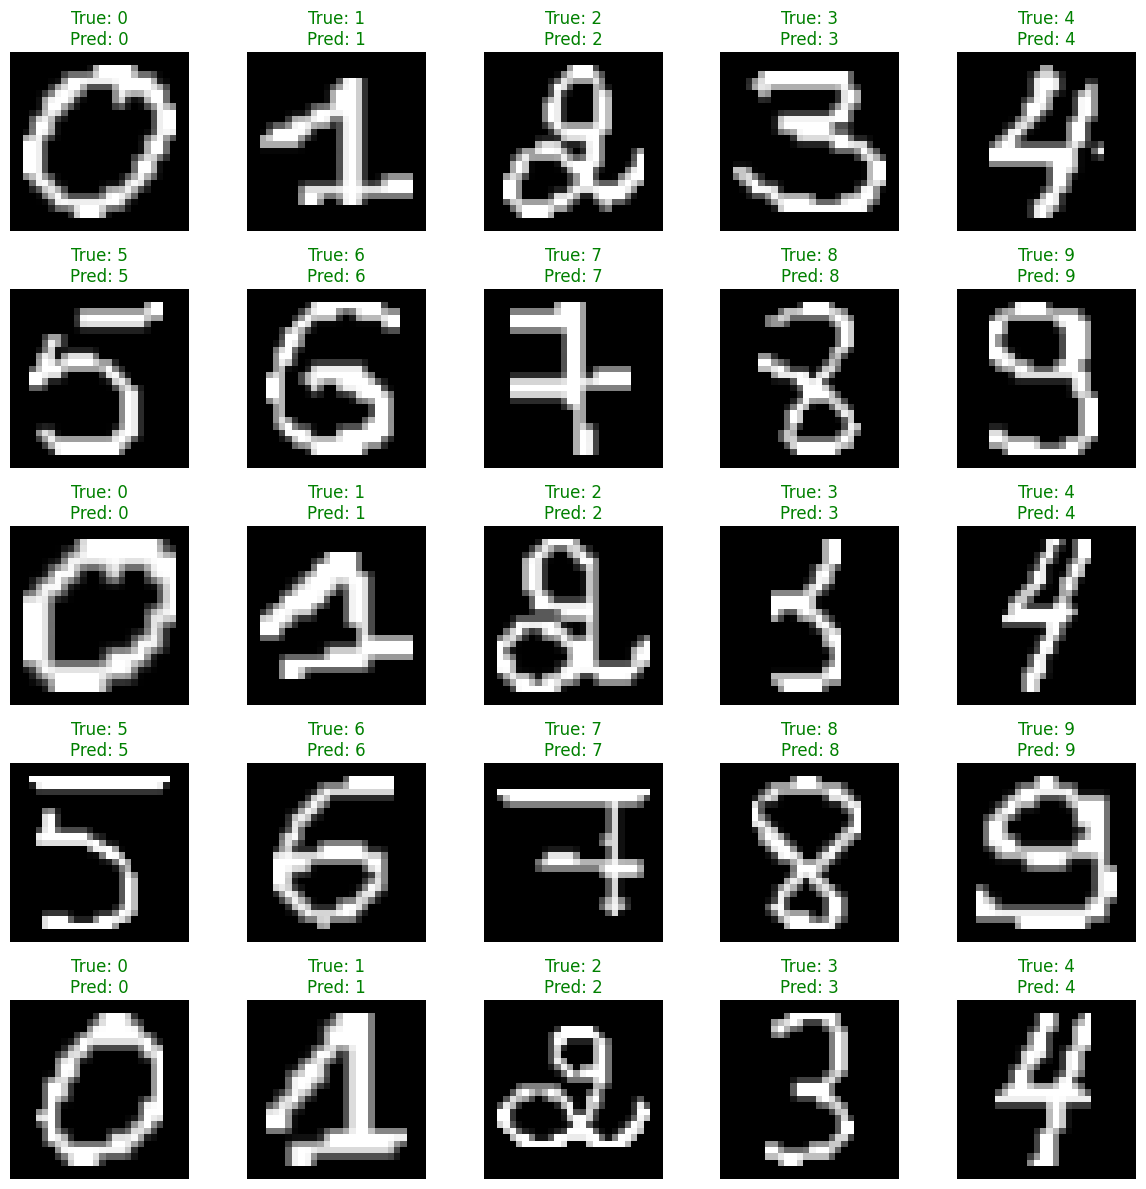

In [29]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.ravel()

for i in range(25):
    img = x_test[i].reshape(28, 28)
    true_label = y_test[i]
    pred_label = y_pred_classes[i]
    
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    if true_label == pred_label:
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color='green')
    else:
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', color='red')

plt.tight_layout()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9911 - loss: 0.0349   
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9741 - loss: 0.0740
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9973 - loss: 0.0211
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9467 - loss: 0.2302
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7400 - loss: 0.9385 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9493 - loss: 0.1853 
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8559 - loss: 0.7090
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8577 - loss: 0.4010 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9442 - loss: 0.1720
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9725 - loss: 0.0820 
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.8256e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0278 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9481 - loss: 0.1529 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.

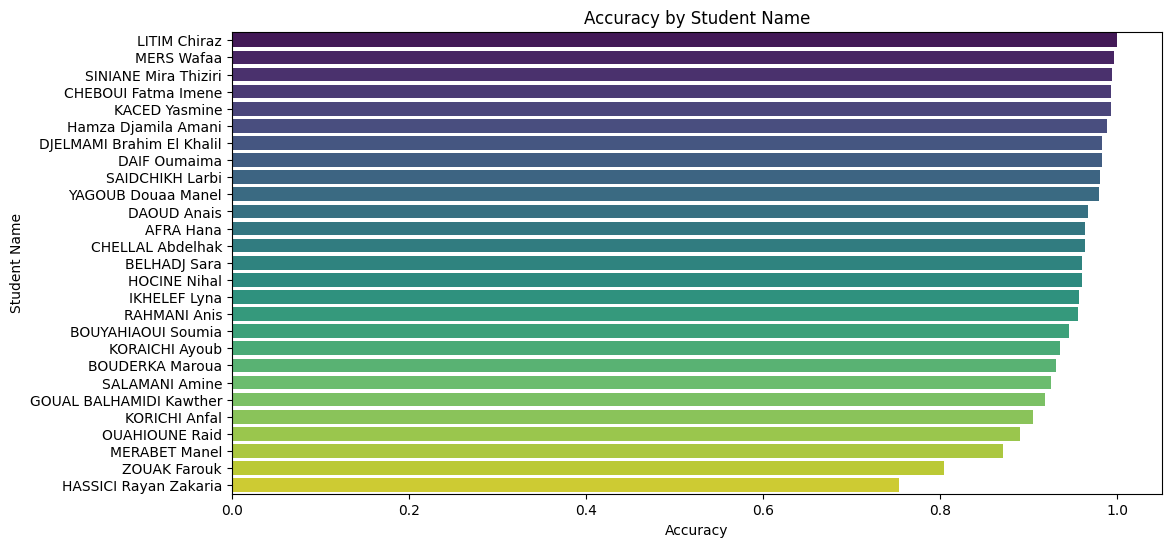

In [33]:
# Get the accuracies by student name
names = list(set(df_old['student name'].values.tolist()))
accuracies = []
for name in names:
    selector = (df_old['student name'] == name)
    _, accuracy = model.evaluate(x_test[selector], y_test[selector])
    accuracies.append(accuracy)

# Create a DataFrame to store the results
df_results = pd.DataFrame({'name': names, 'accuracy': accuracies})
df_results = df_results.sort_values('accuracy', ascending=False)

# Plot the accuracies
plt.figure(figsize=(12, 6))
sns.barplot(x='accuracy', y='name', data=df_results, palette='viridis')
plt.xlabel('Accuracy')
plt.ylabel('Student Name')
plt.title('Accuracy by Student Name')
plt.show()

In [38]:
df_results.sort_values('accuracy', ascending=False)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


,name,accuracy
10,LITIM Chiraz,1.000000
2,MERS Wafaa,0.996429
20,SINIANE Mira Thiziri,0.993750
11,CHEBOUI Fatma Imene,0.992857
18,KACED Yasmine,0.992857
0,Hamza Djamila Amani,0.988550
19,DJELMAMI Brahim El Khalil,0.982143
24,DAIF Oumaima,0.982143
1,SAIDCHIKH Larbi,0.979914
9,YAGOUB Douaa Manel,0.978571


              precision    recall  f1-score      support
0              0.970950  0.949727  0.960221   915.000000
1              0.909543  0.968254  0.937981   945.000000
2              0.951872  0.952891  0.952381   934.000000
3              0.977804  0.906826  0.940978   923.000000
4              0.947537  0.968271  0.957792   914.000000
5              0.936145  0.918440  0.927208   846.000000
6              0.908228  0.979522  0.942529   879.000000
7              0.954338  0.950000  0.952164   880.000000
8              0.953283  0.886150  0.918491   852.000000
9              0.947545  0.964773  0.956081   880.000000
accuracy       0.944915  0.944915  0.944915     0.944915
macro avg      0.945724  0.944485  0.944583  8968.000000
weighted avg   0.945775  0.944915  0.944823  8968.000000


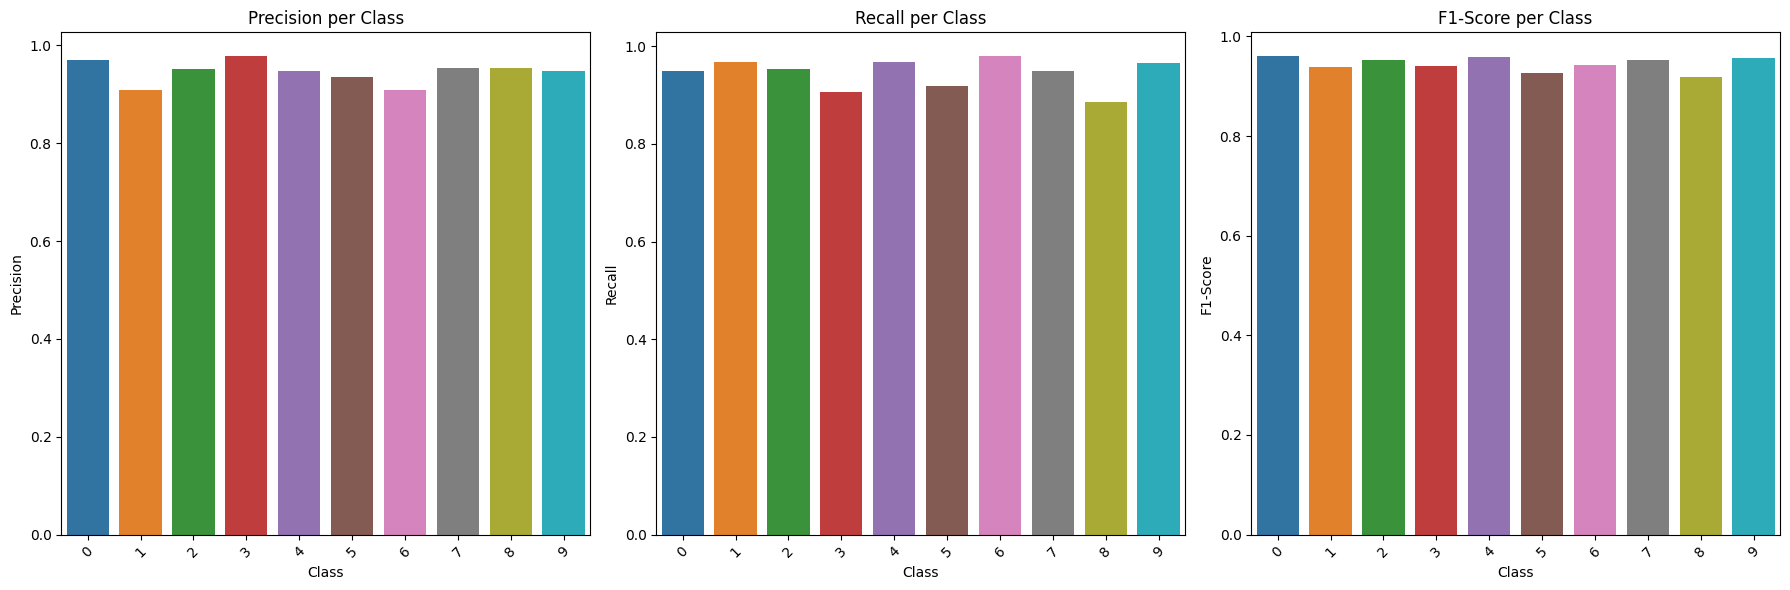

In [36]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred_classes, output_dict=True)

# Convert the report to a DataFrame for better visualization
df_report = pd.DataFrame(report).transpose()

# Display the report
print(df_report)

# Plot the precision, recall, and f1-score for each class
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x=df_report.index[:-3], y=df_report['precision'][:-3], ax=ax[0])
ax[0].set_title('Precision per Class')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Precision')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

sns.barplot(x=df_report.index[:-3], y=df_report['recall'][:-3], ax=ax[1])
ax[1].set_title('Recall per Class')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Recall')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

sns.barplot(x=df_report.index[:-3], y=df_report['f1-score'][:-3], ax=ax[2])
ax[2].set_title('F1-Score per Class')
ax[2].set_xlabel('Class')
ax[2].set_ylabel('F1-Score')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

Let's try to compare with the accuracy we'd get when testing on MNIST dataset..

In [37]:
x_test1 = MNIST_x_test / 255.0
x_test1 = np.expand_dims(x_test1, -1)

print("Model evaluation on MNIST...")
loss, accuracy = model.evaluate(x_test1, MNIST_y_test)

Model evaluation on MNIST...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7953 - loss: 0.8213


**79.53%**! That's a significant drop in performance but still performing good! It is due to the difference between our dataset and the Mnist one.


### Experiment 2: training using New data + MNIST


In [55]:
# Combine features and labels
merged_X = np.vstack((MNIST_x_train, new_X))
merged_y = np.vstack((MNIST_y_train.reshape(-1, 1), new_y.reshape(-1, 1)))

# Print the shapes
print(f"Merged data shape: {merged_X.shape}")
print(f"Merged labels shape: {merged_y.shape}")

Merged data shape: (100274, 28, 28)
Merged labels shape: (100274, 1)


In [59]:
x_train, x_val, y_train, y_val = train_test_split(
    merged_X, merged_y, test_size=0.2, random_state=42, shuffle=True
)

x_train = x_train / 255.0
x_val = x_val / 255.0

x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)

print("train-set size:", x_train.shape)
print("val-set size:", x_val.shape)
print("test-set size:", x_test.shape)

train-set size: (80219, 28, 28, 1)
val-set size: (20055, 28, 28, 1)
test-set size: (8968, 28, 28, 1)


### Model building

In [60]:
model = LeNet5(dropout=dropout_rate, l2_reg=l2_reg_rate)

opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss = loss_m, metrics = ["accuracy"])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 24, 24, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 12, 12, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 12, 12, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 16)            │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 4, 4, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 120)                 │          30,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_22 (Activation)           │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │             850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,426 (173.54 KB)

 Trainable params: 44,426 (173.54 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
h = model.fit(x_train, y_train, epochs = epochs, batch_size=batch_size, validation_data = (x_val, y_val), shuffle = True)

Epoch 1/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.6921 - loss: 0.8924 - val_accuracy: 0.9570 - val_loss: 0.1440
Epoch 2/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9335 - loss: 0.2166 - val_accuracy: 0.9686 - val_loss: 0.1055
Epoch 3/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9493 - loss: 0.1700 - val_accuracy: 0.9743 - val_loss: 0.0856
Epoch 4/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9586 - loss: 0.1430 - val_accuracy: 0.9751 - val_loss: 0.0777
Epoch 5/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9611 - loss: 0.1336 - val_accuracy: 0.9778 - val_loss: 0.0762
Epoch 6/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9639 - loss: 0.1240 - val_accuracy: 0.9794 - val_loss: 0.0678
Epoch 7/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9671 - loss: 0.1108 - val_accuracy: 0.9809 - val_loss: 0.0645
Epoch 8/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9687 - loss: 0.1043 -

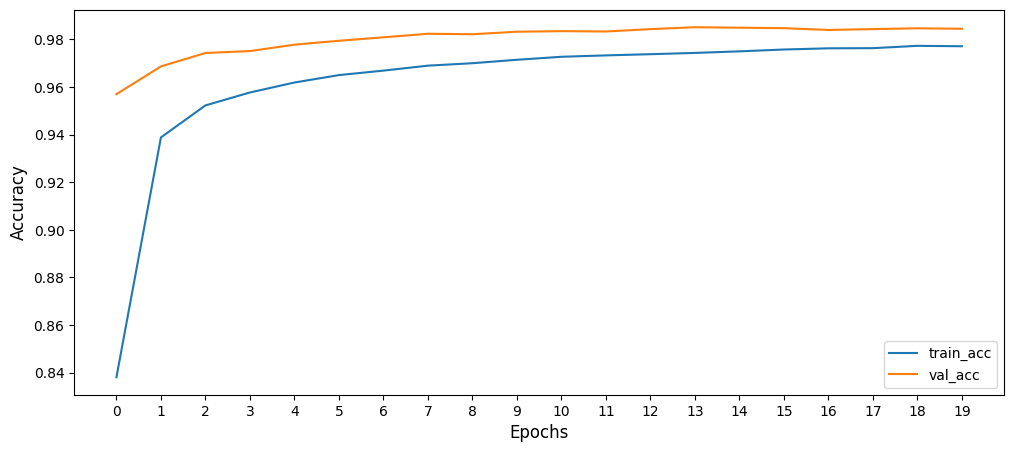

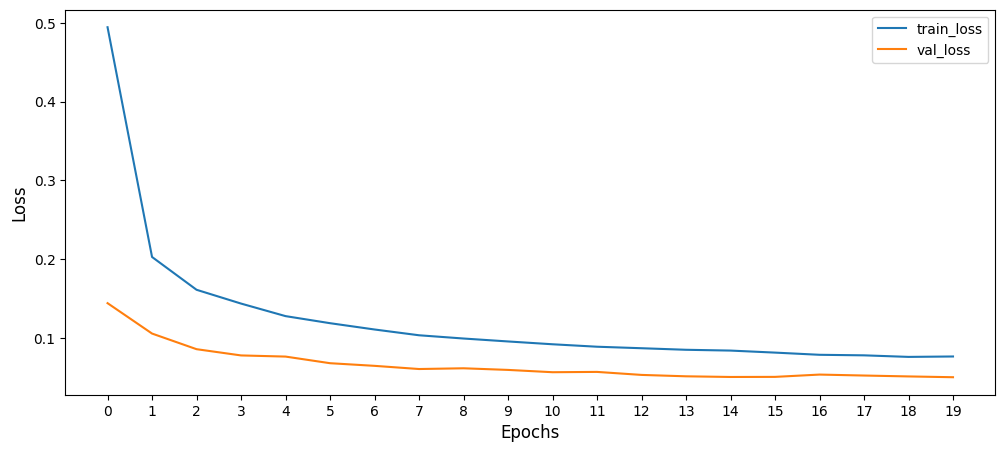

In [62]:
plt.figure(figsize=(12, 5))
plt.plot(h.history["accuracy"], label = "train_acc")
plt.plot(h.history["val_accuracy"], label = "val_acc")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.xticks(range(epochs))
plt.legend()

plt.figure(figsize=(12, 5))
plt.plot(h.history["loss"], label = "train_loss")
plt.plot(h.history["val_loss"], label = "val_loss")
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.xticks(range(epochs))
plt.legend()

plt.show()

In [63]:
print("Model evaluation...")

loss, accuracy = model.evaluate(x_test, y_test.reshape(-1, 1))

Model evaluation...
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9529 - loss: 0.1688


we got **95.29** on the test data which is slightly better than the first one!

### comparing on testing with MNIST test data

In [64]:
x_test1 = MNIST_x_test / 255.0
x_test1 = np.expand_dims(x_test1, -1)

print("Model evaluation on MNIST...")
loss, accuracy = model.evaluate(x_test1, MNIST_y_test)

Model evaluation on MNIST...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9860 - loss: 0.0427


**98.60** vs **79** ! We got a significant improvement 